In [1]:
%load_ext autoreload
%autoreload 2

# import sys, os
# sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
# os.environ['PYTHONPATH'] = ':'.join(sys.path)

In [2]:
import numpy as np
from copy import deepcopy
import uproot
from hepattn.experiments.clic.performance.performance import Performance
from hepattn.experiments.clic.performance.plot_helper_event import *
from hepattn.experiments.clic.performance.plot_helper_particle import *
import matplotlib.pyplot as plt

In [3]:
save_dir = "maskformer_infer_best"
SAVE_FIG = False

In [4]:
os.makedirs(save_dir, exist_ok=True)

In [5]:
net_dict = {
    # "mpflow": "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFix_20250611-T181526/ckpts/epoch=172-val_loss=3.29018__test.root",
    # "mpflow": "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFoc_20250612-T131052/ckpts/epoch=195-val_loss=3.42870__test.root",
    # "mpflow":   "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFoc_20250612-T131052/ckpts/epoch=195-val_loss=3.42870__test__common.root",
    "mpflow": "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFocFix_20250613-T142512/ckpts/epoch=159-val_loss=3.51694__test__common.root",
    "hgpflow": "/storage/agrp/nilotpal/HGPFlow_v2/experiments/hgpflow_v2/clicxminixbig1x2xs2xxxds7kirm1yo/inference/ee_qq_new/pred_test_p8_ee_qq_ecm380_20k_seg_bw0.3_nocut_merged.root",
    # 'hgpflow'
}

In [6]:
perf_obj = Performance(
    truth_path="/storage/agrp/dmitrykl/hgpf/hepformer/data/nilo/test_clic_common_raw.root",
    # truth_path="/storage/agrp/dmitrykl/hgpf/hepformer/data/nilo/test_clic_raw.root",
    networks=net_dict,
    # num_events=18000,
    # num_events={
    #     'mpflow' : 25_000,
    # }
)

E, pT will be scaled by 1


Reading truth tree...: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]


Number of events with at least one track or topocluster: 19998 out of 20000
[[ 1399]
 [11288]]
Number of events after filtering: 19998


Computing HGPFlow mass...: 100%|██████████| 19998/19998 [00:00<00:00, 56305.05it/s]


In [7]:
perf_obj.reorder_and_find_intersection()

common event count: 19722


Filtering and reordering hgpflow...: 100%|██████████| 12/12 [00:00<00:00, 1823.02it/s]


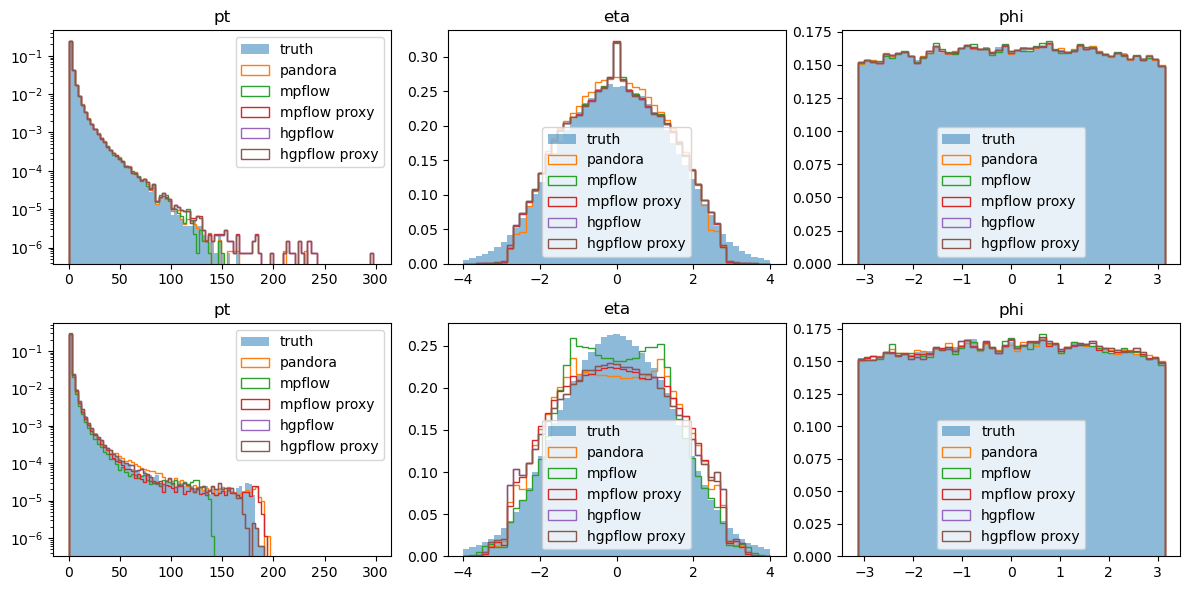

In [8]:
bins = [
    np.linspace(0, 300, 100),
    np.linspace(-4, 4, 50),
    np.linspace(-np.pi, np.pi, 50),
]
var_names = ["pt", "eta", "phi"]
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
mask_fns = [
    lambda x: x < 3,
    lambda x: (x < 5) & (x > 2),
]
truth_class = np.concatenate(perf_obj.truth_dict["particle_class"])
pandora_class = np.concatenate(perf_obj.truth_dict["pandora_class"])

for i in range(3):
    for j in range(2):
        ax[j, i].hist(
            np.concatenate(perf_obj.truth_dict["particle_" + var_names[i]])[mask_fns[j](truth_class)],
            bins=bins[i],
            histtype="stepfilled",
            alpha=0.5,
            label="truth",
            density=True,
        )
        ax[j, i].hist(
            np.concatenate(perf_obj.truth_dict["pandora_" + var_names[i]])[mask_fns[j](pandora_class)],
            bins=bins[i],
            histtype="step",
            label="pandora",
            density=True,
        )
        for key, value in perf_obj.data.items():
            pf_class = np.concatenate(value[f"class"])
            ax[j, i].hist(
                np.concatenate(value[var_names[i]])[mask_fns[j](pf_class)],
                bins=bins[i],
                histtype="step",
                label=key,
                density=True,
            )
            if key in {"hgpflow", "mpflow"}:
                ax[j, i].hist(
                    np.concatenate(value["proxy_" + var_names[i]])[mask_fns[j](pf_class)],
                    bins=bins[i],
                    histtype="step",
                    label=key + " proxy",
                    density=True,
                )
        ax[j, i].set_title(var_names[i])
        ax[j, i].legend()
        ax[j, 0].set_yscale("log")

plt.tight_layout()
plt.show()

In [9]:
def get_n_particles(data_dict, key="class"):
    n_charged = []
    n_neutral = []
    for i in range(len(data_dict[key])):
        ch_mask = data_dict[key][i] <= 2
        n_charged.append(np.sum(ch_mask))
        n_neutral.append(np.sum(~ch_mask))
    return np.array(n_charged), np.array(n_neutral)

In [10]:
n_charged_truth, n_neutral_truth = get_n_particles(perf_obj.truth_dict, key="particle_class")
n_charged_pandora, n_neutral_pandora = get_n_particles(perf_obj.truth_dict, key="pandora_class")

for key in perf_obj.data.keys():
    n_charged, n_neutral = get_n_particles(perf_obj.data[key])
    perf_obj.data[key]["n_charged"] = n_charged
    perf_obj.data[key]["n_neutral"] = n_neutral

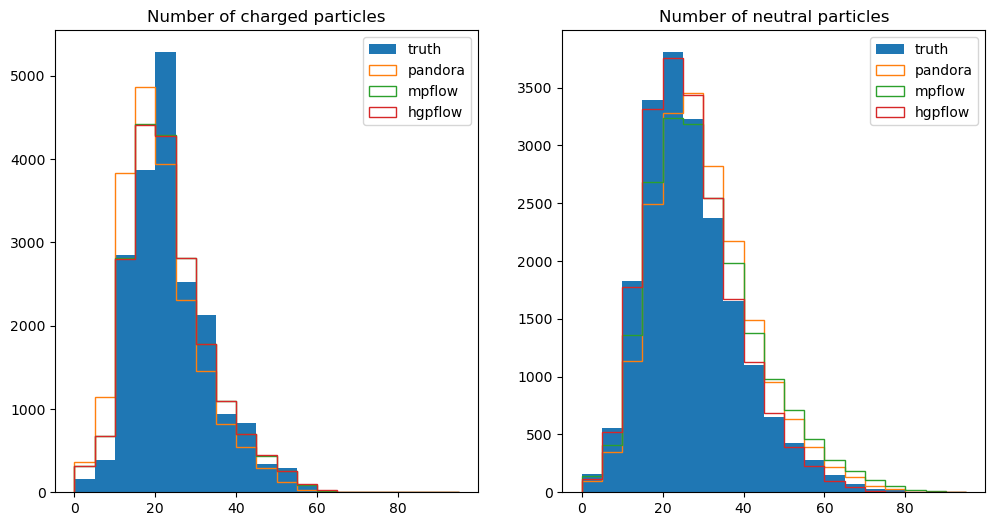

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(n_charged_truth, bins=np.arange(0, 100, 5), histtype="stepfilled", label="truth")
ax[1].hist(n_neutral_truth, bins=np.arange(0, 100, 5), histtype="stepfilled", label="truth")
ax[0].hist(n_charged_pandora, bins=np.arange(0, 100, 5), histtype="step", label="pandora")
ax[1].hist(n_neutral_pandora, bins=np.arange(0, 100, 5), histtype="step", label="pandora")
for key in perf_obj.data.keys():
    n_charged, n_neutral = perf_obj.data[key]["n_charged"], perf_obj.data[key]["n_neutral"]
    ax[0].hist(n_charged, bins=np.arange(0, 100, 5), histtype="step", label=key)
    ax[1].hist(n_neutral, bins=np.arange(0, 100, 5), histtype="step", label=key)
ax[0].legend()
ax[1].legend()
ax[0].set_title("Number of charged particles")
ax[1].set_title("Number of neutral particles")
plt.show()

In [12]:
from scipy.stats import iqr

In [13]:
def _add_hist(ax, data, bins, label, histtype="step", **kwargs):
    mean, iqr_ = np.mean(data), iqr(data)
    label = f"{label}: $\mu$={mean:.2f}, iqr={iqr_:.2f}"
    ax.hist(data, bins=bins, histtype=histtype, label=label, **kwargs)

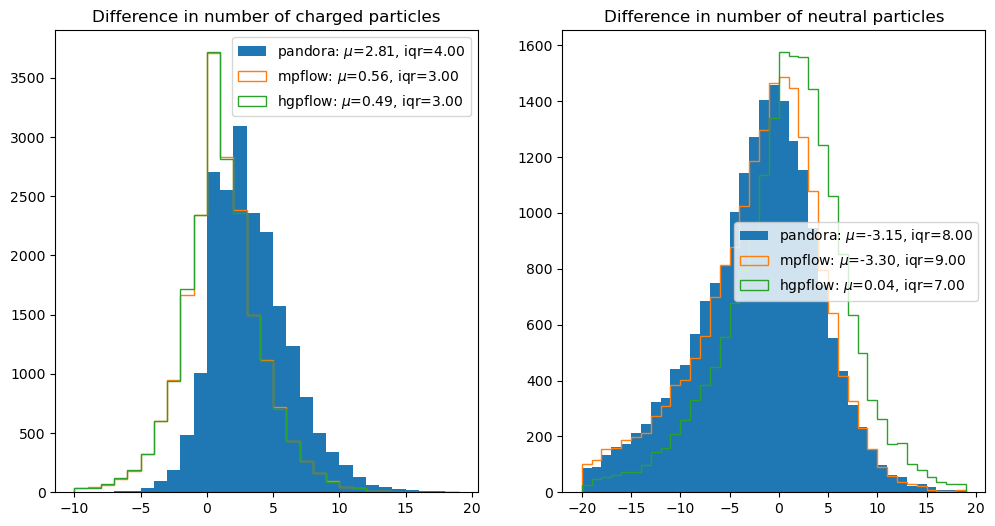

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
_add_hist(ax[0], n_charged_truth - n_charged_pandora, bins=np.arange(-10, 20, 1), histtype="stepfilled", label="pandora")
_add_hist(ax[1], n_neutral_truth - n_neutral_pandora, bins=np.arange(-20, 20, 1), histtype="stepfilled", label="pandora")
for key in perf_obj.data.keys():
    n_charged, n_neutral = perf_obj.data[key]["n_charged"], perf_obj.data[key]["n_neutral"]
    _add_hist(ax[0], n_charged_truth - n_charged, bins=np.arange(-10, 20, 1), label=key, histtype="step")
    _add_hist(ax[1], n_neutral_truth - n_neutral, bins=np.arange(-20, 20, 1), label=key, histtype="step")
ax[0].legend()
ax[1].legend()
ax[0].set_title("Difference in number of charged particles")
ax[1].set_title("Difference in number of neutral particles")
plt.show()

(array([ 237., 1129., 4749., 5518., 3992., 2092., 1020.,  688.,  260.,
          37.]),
 array([  0. ,  12.7,  25.4,  38.1,  50.8,  63.5,  76.2,  88.9, 101.6,
        114.3, 127. ]),
 <BarContainer object of 10 artists>)

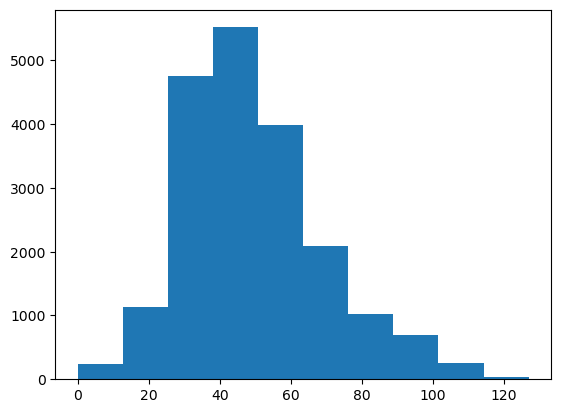

In [15]:
plt.hist(n_charged + n_neutral)

### Overwrite

- `hgpflow_pt` for neutral particles is better than `proxy_pt`
- But the rest are just worse
- So, I will just overwrite the `hgpflow_xxx` with `proxy_xxx` for the rest

In [16]:
perf_obj.data["hgpflow"]["eta"] = perf_obj.data["hgpflow"]["proxy_eta"]
perf_obj.data["hgpflow"]["phi"] = perf_obj.data["hgpflow"]["proxy_phi"]
perf_obj.data["hgpflow"]["pt"] = perf_obj.data["hgpflow"]["proxy_pt"]

for i in range(len(perf_obj.data["hgpflow"]["pt"])):
    ch_mask = perf_obj.data["hgpflow"]["class"][i] <= 2
    perf_obj.data["hgpflow"]["pt"][i][ch_mask] = perf_obj.data["hgpflow"]["proxy_pt"][i][ch_mask]

In [17]:
idx = 0

print("Particle data")
print(np.sort(perf_obj.truth_dict["particle_pt"][idx][perf_obj.truth_dict["particle_class"][idx] <= 2])[::-1])
print("MPflow proxy data")
print(np.sort(perf_obj.data["mpflow"]["proxy_pt"][idx][perf_obj.data["mpflow"]["class"][idx] <= 2])[::-1])
# print("HGPflow proxy data")
# print(np.sort(perf_obj.data['hgpflow']['proxy_pt'][idx][perf_obj.data['hgpflow']['class'][idx] <= 2])[::-1])

Particle data
[2.05544543 2.00689816 1.22862697 1.21958816 0.94735843 0.93824512
 0.68863207 0.58046174 0.57142735 0.56641656 0.51084858 0.45804888
 0.45783955 0.3199735  0.26255557 0.26148829 0.2348657  0.2299964
 0.22890501 0.17870697]
MPflow proxy data
[2.055761   2.0023139  1.2279531  1.2232833  0.94966733 0.946075
 0.6072137  0.5837236  0.5793992  0.5742155  0.5266971  0.45971563
 0.45850793 0.3203549  0.26150483 0.23455955 0.22790605 0.18378448
 0.14520137]


In [18]:
with uproot.open("/storage/agrp/dmitrykl/hgpf/hepformer/data/nilo/test_clic_common_infer.root") as f:
    track_pt = f["EventTree"]["track_pt"].array(library="np")

In [19]:
track_pt[0]

array([2.0557632 , 2.0023131 , 1.2279536 , 0.9496677 , 0.94607526,
       0.6072147 , 0.57421523, 0.52669734, 0.45971552, 0.45850766,
       0.26150492, 0.14520171, 0.23455974, 0.22790611, 0.183785  ,
       1.2232844 , 0.3203548 , 0.5793999 , 0.5837239 ], dtype=float32)

In [20]:
perf_obj.compute_jets(n_procs=20)
perf_obj.match_jets()

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7
truth
Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   0%|          | 0/986 [00:00<?, ?it/s]36.63it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   0%|          | 0/986 [00:00<?, ?it/s]35.96it/s]

Jet clustering algorithm:  genkt
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#-------------------------------------

Computing jets...:   2%|▏         | 21/986 [00:00<00:04, 208.69it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  23%|██▎       | 229/986 [00:00<00:01, 392.12it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  22%|██▏       | 221/986 [00:00<00:01, 396.73it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#----------------------------------------------------------------------

Computing jets...:  23%|██▎       | 229/986 [00:00<00:01, 396.59it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   2%|▏         | 24/986 [00:00<00:04, 237.41it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  39%|███▉      | 383/986 [00:01<00:01, 393.42it/s]

Jet clustering algorithm:  genkt#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#--------------------------------------

Computing jets...:  23%|██▎       | 227/986 [00:00<00:01, 380.67it/s]

Computing jets...:  49%|████▉     | 486/986 [00:01<00:01, 412.97it/s]

Jet clustering algorithm:  genkt


Computing jets...:  43%|████▎     | 424/986 [00:01<00:01, 396.28it/s]

Jet clustering radius: 0.7


Computing jets...:  19%|█▊        | 183/986 [00:00<00:02, 380.86it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  36%|███▌      | 351/986 [00:00<00:01, 392.74it/s]

Jet clustering algorithm:  genkt#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#--------------------------------------

Computing jets...:  14%|█▍        | 140/987 [00:00<00:02, 364.20it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  64%|██████▍   | 633/986 [00:01<00:00, 407.91it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  26%|██▋       | 260/987 [00:00<00:01, 388.39it/s]

Jet clustering algorithm: #--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#--------------------------------------------

Computing jets...:  34%|███▍      | 340/986 [00:00<00:01, 376.65it/s]


Jet clustering radius:  0.7


Computing jets...:  61%|██████    | 599/986 [00:01<00:00, 403.86it/s]

Jet clustering algorithm:  genkt
Jet clustering radius: 

Computing jets...:  34%|███▍      | 338/987 [00:00<00:01, 384.92it/s]

 0.7


Computing jets...:  19%|█▉        | 188/986 [00:00<00:02, 323.38it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Computing jets...:  27%|██▋       | 263/986 [00:00<00:01, 363.91it/s]

Jet clustering algorithm:  genkt
Jet clustering radius: 

Computing jets...:  62%|██████▏   | 610/986 [00:01<00:00, 386.58it/s]

 0.7#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------



Computing jets...:  72%|███████▏  | 709/986 [00:01<00:00, 392.43it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  

Computing jets...:  97%|█████████▋| 959/986 [00:02<00:00, 373.01it/s]

0.7


Computing jets...:  19%|█▊        | 183/986 [00:00<00:02, 355.65it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  85%|████████▌ | 841/986 [00:02<00:00, 405.29it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#----------------------------------------------------------------------

Computing jets...:  23%|██▎       | 229/986 [00:00<00:03, 249.76it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  79%|███████▊  | 776/987 [00:02<00:00, 387.36it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Computing jets...: 100%|██████████| 987/987 [00:02<00:00, 386.29it/s]


Jet clustering algorithm:  genkt
pandora
Jet clustering radius:  0.7


Computing jets...:   4%|▍         | 44/986 [00:00<00:02, 434.75it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|▍         | 37/986 [00:00<00:02, 368.62it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|▍         | 38/986 [00:00<00:02, 372.24it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  12%|█▏        | 116/986 [00:00<00:02, 388.64it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  20%|█▉        | 196/986 [00:00<00:02, 388.96it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|▍         | 42/986 [00:00<00:02, 414.42it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|▎         | 35/986 [00:00<00:02, 342.32it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  51%|█████▏    | 507/986 [00:01<00:01, 405.10it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  26%|██▌       | 253/986 [00:00<00:01, 388.73it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  45%|████▌     | 448/986 [00:01<00:01, 383.19it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  29%|██▉       | 288/986 [00:00<00:01, 392.24it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  43%|████▎     | 422/986 [00:01<00:01, 400.90it/s]

Jet clustering algorithm: 

Computing jets...:  67%|██████▋   | 663/986 [00:01<00:00, 404.58it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  16%|█▌        | 160/986 [00:00<00:02, 395.52it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  41%|████      | 403/986 [00:01<00:01, 387.22it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  41%|████      | 406/986 [00:01<00:01, 401.50it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  23%|██▎       | 231/986 [00:00<00:01, 380.06it/s]

Computing jets...:  83%|████████▎ | 815/986 [00:02<00:00, 400.35it/s]

Jet clustering algorithm:  genkt
Jet clustering radius: 0.7


Computing jets...:  41%|████      | 400/987 [00:01<00:01, 401.72it/s]

Jet clustering algorithm:  genkt

Computing jets...:  58%|█████▊    | 567/986 [00:01<00:01, 397.09it/s]


Jet clustering radius:  0.7


Computing jets...:  76%|███████▌  | 745/986 [00:01<00:00, 377.71it/s]

Jet clustering algorithm:  genkt

Computing jets...:  45%|████▌     | 447/986 [00:01<00:01, 410.00it/s]


Jet clustering radius:  0.7


Computing jets...:  74%|███████▍  | 734/986 [00:01<00:00, 388.92it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...: 100%|██████████| 987/987 [00:02<00:00, 342.93it/s]


Jet clustering algorithm:  genkt
mpflow jets
Jet clustering radius:  0.7


Computing jets...:   4%|▎         | 36/986 [00:00<00:02, 353.28it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   0%|          | 0/986 [00:00<?, ?it/s]40.96it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  11%|█         | 110/986 [00:00<00:02, 312.86it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 30/986 [00:00<00:03, 296.58it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|▎         | 36/986 [00:00<00:02, 353.52it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|▍         | 37/986 [00:00<00:02, 353.70it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  24%|██▍       | 237/986 [00:00<00:02, 310.48it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  34%|███▎      | 331/986 [00:01<00:01, 333.90it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 33/986 [00:00<00:02, 326.61it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 31/987 [00:00<00:03, 305.26it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  17%|█▋        | 164/986 [00:00<00:02, 304.27it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  59%|█████▉    | 586/986 [00:01<00:01, 327.90it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 25/986 [00:00<00:03, 245.72it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  17%|█▋        | 163/986 [00:00<00:02, 318.32it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   2%|▏         | 16/986 [00:00<00:06, 158.56it/s]]

Jet clustering algorithm: 

Computing jets...:   0%|          | 0/986 [00:00<?, ?it/s]322.01it/s]


0.7 

Computing jets...:  64%|██████▍   | 634/986 [00:01<00:01, 294.72it/s]

Jet clustering radius: 

Computing jets...:  33%|███▎      | 330/986 [00:01<00:02, 318.92it/s]


genkt 

Computing jets...:  58%|█████▊    | 573/986 [00:01<00:01, 325.33it/s]

Jet clustering algorithm:  

Computing jets...:  26%|██▋       | 259/986 [00:00<00:02, 292.09it/s]

genkt


Computing jets...:  62%|██████▏   | 612/986 [00:01<00:01, 323.77it/s]

Jet clustering radius:  

Computing jets...:   6%|▌         | 61/986 [00:00<00:03, 307.97it/s]

0.7


Computing jets...:  78%|███████▊  | 770/986 [00:02<00:00, 321.29it/s]

Jet clustering algorithm:  

Computing jets...:  39%|███▉      | 387/987 [00:01<00:01, 332.41it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  89%|████████▉ | 876/986 [00:02<00:00, 211.75it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7

Computing jets...:  22%|██▏       | 217/986 [00:00<00:02, 295.35it/s]

Computing jets...:  13%|█▎        | 133/986 [00:00<00:02, 289.33it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...: 100%|██████████| 987/987 [00:03<00:00, 289.34it/s]


Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|▎         | 35/986 [00:00<00:02, 342.80it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|▎         | 35/986 [00:00<00:02, 342.25it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  14%|█▍        | 141/986 [00:00<00:02, 314.13it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  11%|█         | 104/986 [00:00<00:02, 327.54it/s]

Jet clustering algorithm: 

Computing jets...:   6%|▋         | 64/986 [00:00<00:02, 316.06it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:   6%|▌         | 61/986 [00:00<00:03, 297.88it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   9%|▉         | 91/986 [00:00<00:03, 297.47it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 29/986 [00:00<00:03, 287.28it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 28/986 [00:00<00:03, 276.25it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   7%|▋         | 66/986 [00:00<00:02, 316.23it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7

Computing jets...:   9%|▉         | 87/986 [00:00<00:03, 277.53it/s]

Computing jets...:  16%|█▌        | 155/986 [00:00<00:02, 311.54it/s]

Jet clustering algorithm:  

Computing jets...:  26%|██▋       | 259/986 [00:00<00:02, 325.67it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  20%|██        | 201/986 [00:00<00:02, 269.72it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   9%|▉         | 93/987 [00:00<00:02, 304.47it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  49%|████▊     | 479/986 [00:01<00:01, 332.84it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  43%|████▎     | 428/986 [00:01<00:01, 322.33it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  

Computing jets...:  41%|████      | 406/986 [00:01<00:01, 320.41it/s]

0.7


Computing jets...:  68%|██████▊   | 674/986 [00:02<00:01, 237.25it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  22%|██▏       | 217/986 [00:00<00:02, 288.78it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  47%|████▋     | 460/986 [00:01<00:02, 214.77it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  49%|████▉     | 484/986 [00:01<00:02, 211.39it/s]

Jet clustering algorithm:  

Computing jets...:  72%|███████▏  | 710/986 [00:02<00:01, 250.00it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  46%|████▌     | 451/986 [00:01<00:01, 326.85it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...: 100%|██████████| 987/987 [00:03<00:00, 282.55it/s]


Jet clustering algorithm:  genkthgpflow jets

Jet clustering radius:  0.7


Computing jets...:   4%|▍         | 38/986 [00:00<00:02, 374.38it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|▍         | 38/986 [00:00<00:02, 370.08it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 33/986 [00:00<00:02, 327.38it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 32/986 [00:00<00:03, 314.90it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  23%|██▎       | 225/986 [00:00<00:02, 358.53it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|▍         | 38/986 [00:00<00:02, 376.07it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  22%|██▏       | 219/986 [00:00<00:02, 348.57it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  41%|████▏     | 409/986 [00:01<00:01, 358.04it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  36%|███▌      | 357/986 [00:01<00:01, 364.31it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  44%|████▎     | 431/986 [00:01<00:01, 325.92it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  59%|█████▉    | 586/986 [00:01<00:01, 337.37it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  17%|█▋        | 166/986 [00:00<00:02, 338.46it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  58%|█████▊    | 573/986 [00:01<00:01, 343.66it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  17%|█▋        | 171/986 [00:00<00:02, 340.52it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7

Computing jets...:  56%|█████▋    | 555/986 [00:01<00:01, 357.85it/s]

Computing jets...:  60%|█████▉    | 591/986 [00:01<00:01, 352.35it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  18%|█▊        | 174/986 [00:00<00:02, 352.17it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  77%|███████▋  | 756/986 [00:02<00:00, 348.70it/s]

Jet clustering algorithm:  genkt


Computing jets...:  17%|█▋        | 166/986 [00:00<00:02, 318.59it/s]

Jet clustering radius:  0.7


Computing jets...:   9%|▉         | 90/986 [00:00<00:05, 177.06it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  36%|███▌      | 357/986 [00:01<00:01, 345.99it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...: 100%|██████████| 987/987 [00:02<00:00, 330.68it/s]


Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|▍         | 38/986 [00:00<00:02, 368.81it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|▍         | 38/986 [00:00<00:02, 371.68it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 33/986 [00:00<00:02, 325.25it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 32/986 [00:00<00:02, 318.05it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|▍         | 38/986 [00:00<00:02, 370.86it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|▍         | 38/986 [00:00<00:02, 371.21it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|▎         | 32/986 [00:00<00:02, 319.03it/s]]

Jet clustering algorithm:  genkt
Jet clustering radius: 

Computing jets...:  28%|██▊       | 278/986 [00:00<00:02, 309.66it/s]

 0.7


Computing jets...:  30%|██▉       | 295/986 [00:00<00:02, 340.15it/s]

Jet clustering algorithm: 

Computing jets...:  31%|███▏      | 310/986 [00:00<00:02, 295.00it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  34%|███▍      | 340/986 [00:01<00:02, 293.28it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  

Computing jets...:  22%|██▏       | 220/986 [00:00<00:02, 348.71it/s]

0.7


Computing jets...:  22%|██▏       | 220/986 [00:00<00:02, 339.47it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  44%|████▍     | 434/986 [00:01<00:01, 303.80it/s]

Jet clustering algorithm:  

Computing jets...:  40%|████      | 395/986 [00:01<00:01, 338.39it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  19%|█▊        | 184/986 [00:00<00:02, 350.86it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  41%|████      | 406/986 [00:01<00:01, 356.07it/s]

Jet clustering algorithm:  genkt

Computing jets...:  22%|██▏       | 220/986 [00:00<00:02, 312.32it/s]


Jet clustering radius:  0.7


Computing jets...:  13%|█▎        | 128/986 [00:00<00:02, 323.65it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  60%|█████▉    | 589/986 [00:01<00:01, 290.88it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  

Computing jets...:  63%|██████▎   | 626/986 [00:01<00:01, 334.89it/s]

0.7


Computing jets...:  62%|██████▏   | 607/986 [00:01<00:01, 333.34it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  66%|██████▌   | 648/986 [00:02<00:01, 234.86it/s]

Jet clustering algorithm:  

Computing jets...:  17%|█▋        | 172/986 [00:00<00:02, 322.91it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  40%|███▉      | 393/986 [00:01<00:02, 240.87it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  15%|█▌        | 151/986 [00:00<00:04, 201.73it/s]

Jet clustering algorithm:  genkt

Computing jets...:  42%|████▏     | 419/986 [00:01<00:02, 212.96it/s]


Jet clustering radius:  0.7


Matching jets...: 100%|██████████| 19722/19722 [00:00<00:00, 27330.69it/s]


### Jet residual plots

In [21]:
_dict = {
    "pandora": perf_obj.truth_dict["matched_pandora_jets"],
    # 'mlpf': perf_obj.mlpf_dict['matched_mlpf_jets'],
    # 'mpflow': perf_obj.data['mpflow']['matched_jets'],
    "proxy": perf_obj.data["mpflow"]["matched_proxy_jets"],
    "hgpflow": perf_obj.data["hgpflow"]["matched_proxy_jets"],
    # 'hgpflow_target': perf_obj.data['hgpflow_target']['matched_jets'],
}

jet_residual_dict = compute_jet_residual_dict(_dict, dr_cut=0.1, leading_N_jets=2, pt_min=10)

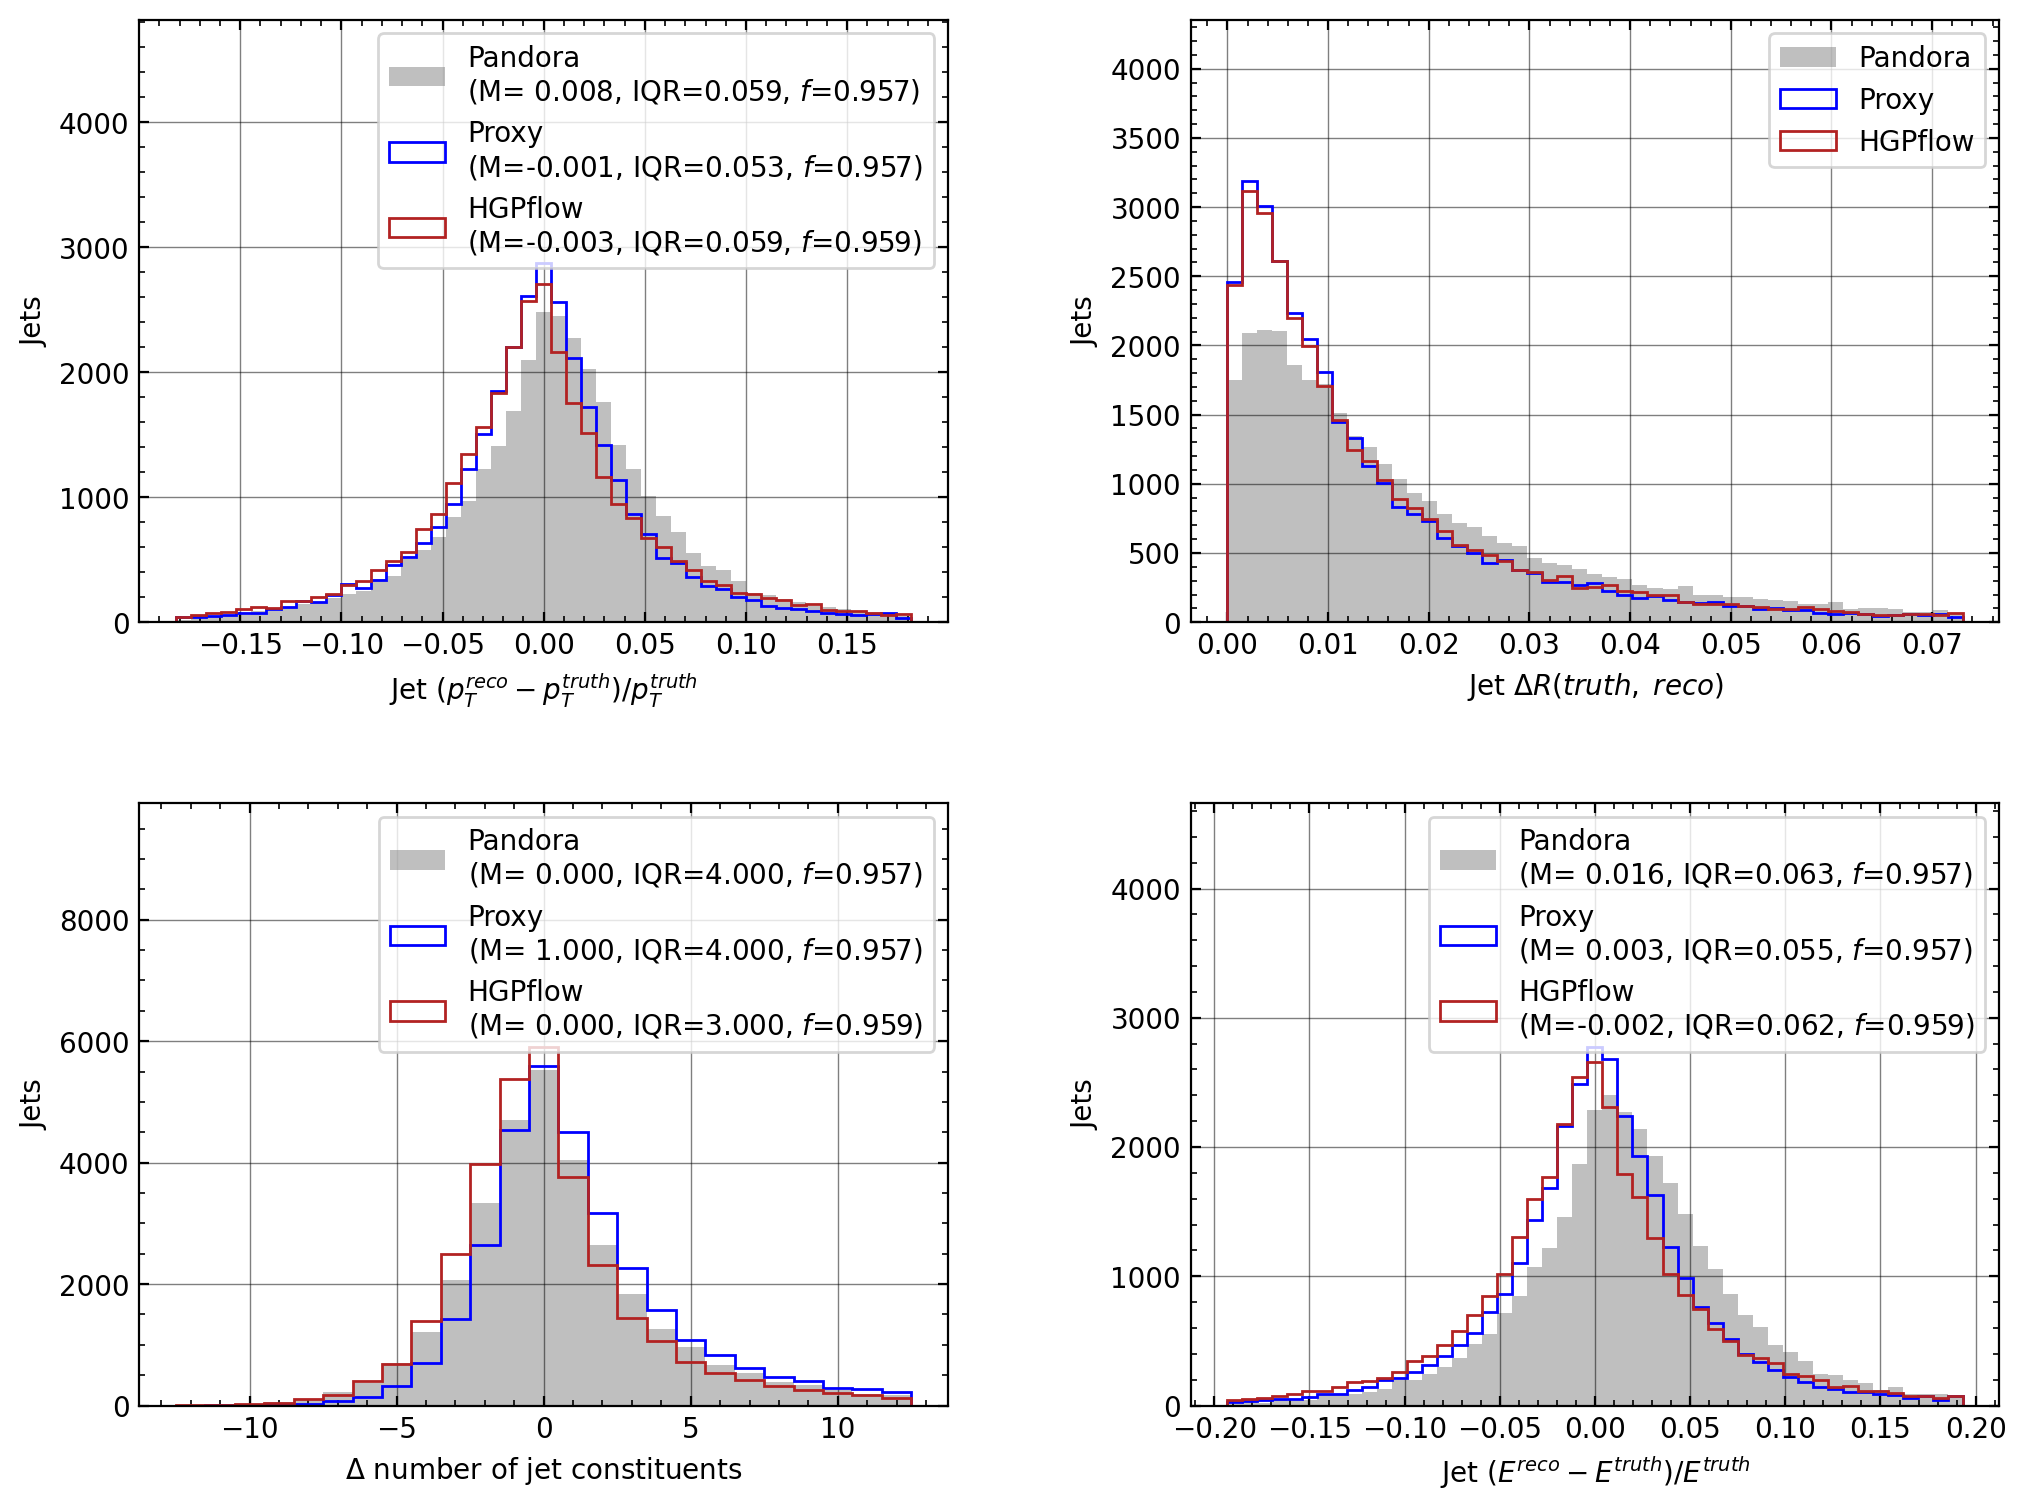

In [22]:
# change the x_lims

figs = plot_jet_residuals(jet_residual_dict, pt_relative=True, separate_figures=False)
if SAVE_FIG:
    if isinstance(figs, list):
        figs[0].savefig(f"{save_dir}/clic_dijet_jet_residuals_pt.png", dpi=300)
        figs[1].savefig(f"{save_dir}/clic_dijet_jet_residuals_dr.png", dpi=300)
        figs[2].savefig(f"{save_dir}/clic_dijet_jet_residuals_constcount.png", dpi=300)
        figs[3].savefig(f"{save_dir}/clic_dijet_jet_residuals_e.png", dpi=300)
    else:
        figs.tight_layout()
        figs.savefig(f"{save_dir}/clic_dijet_jet_residuals.png", dpi=300, bbox_inches="tight")

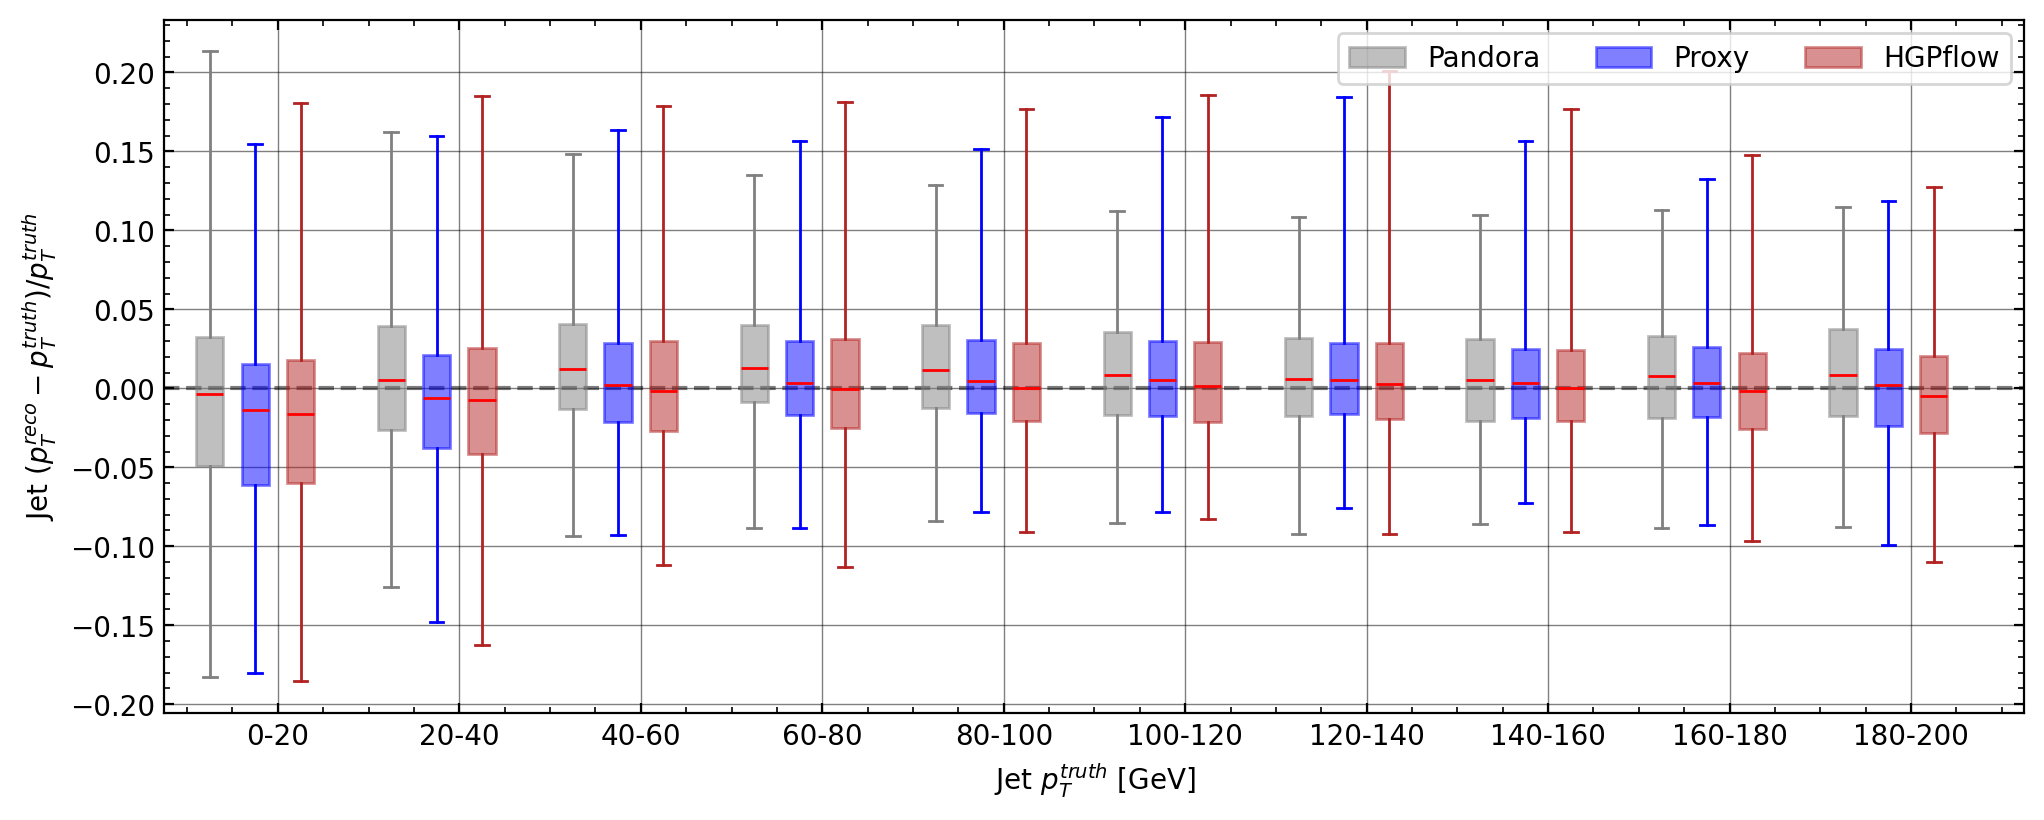

In [23]:
pt_bins = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
fig = plot_jet_res_boxplot(jet_residual_dict, bins=pt_bins, var="pt")
if SAVE_FIG:
    fig.savefig(f"{save_dir}/clic_dijet_jet_residuals_boxplot_pt.png", dpi=300)

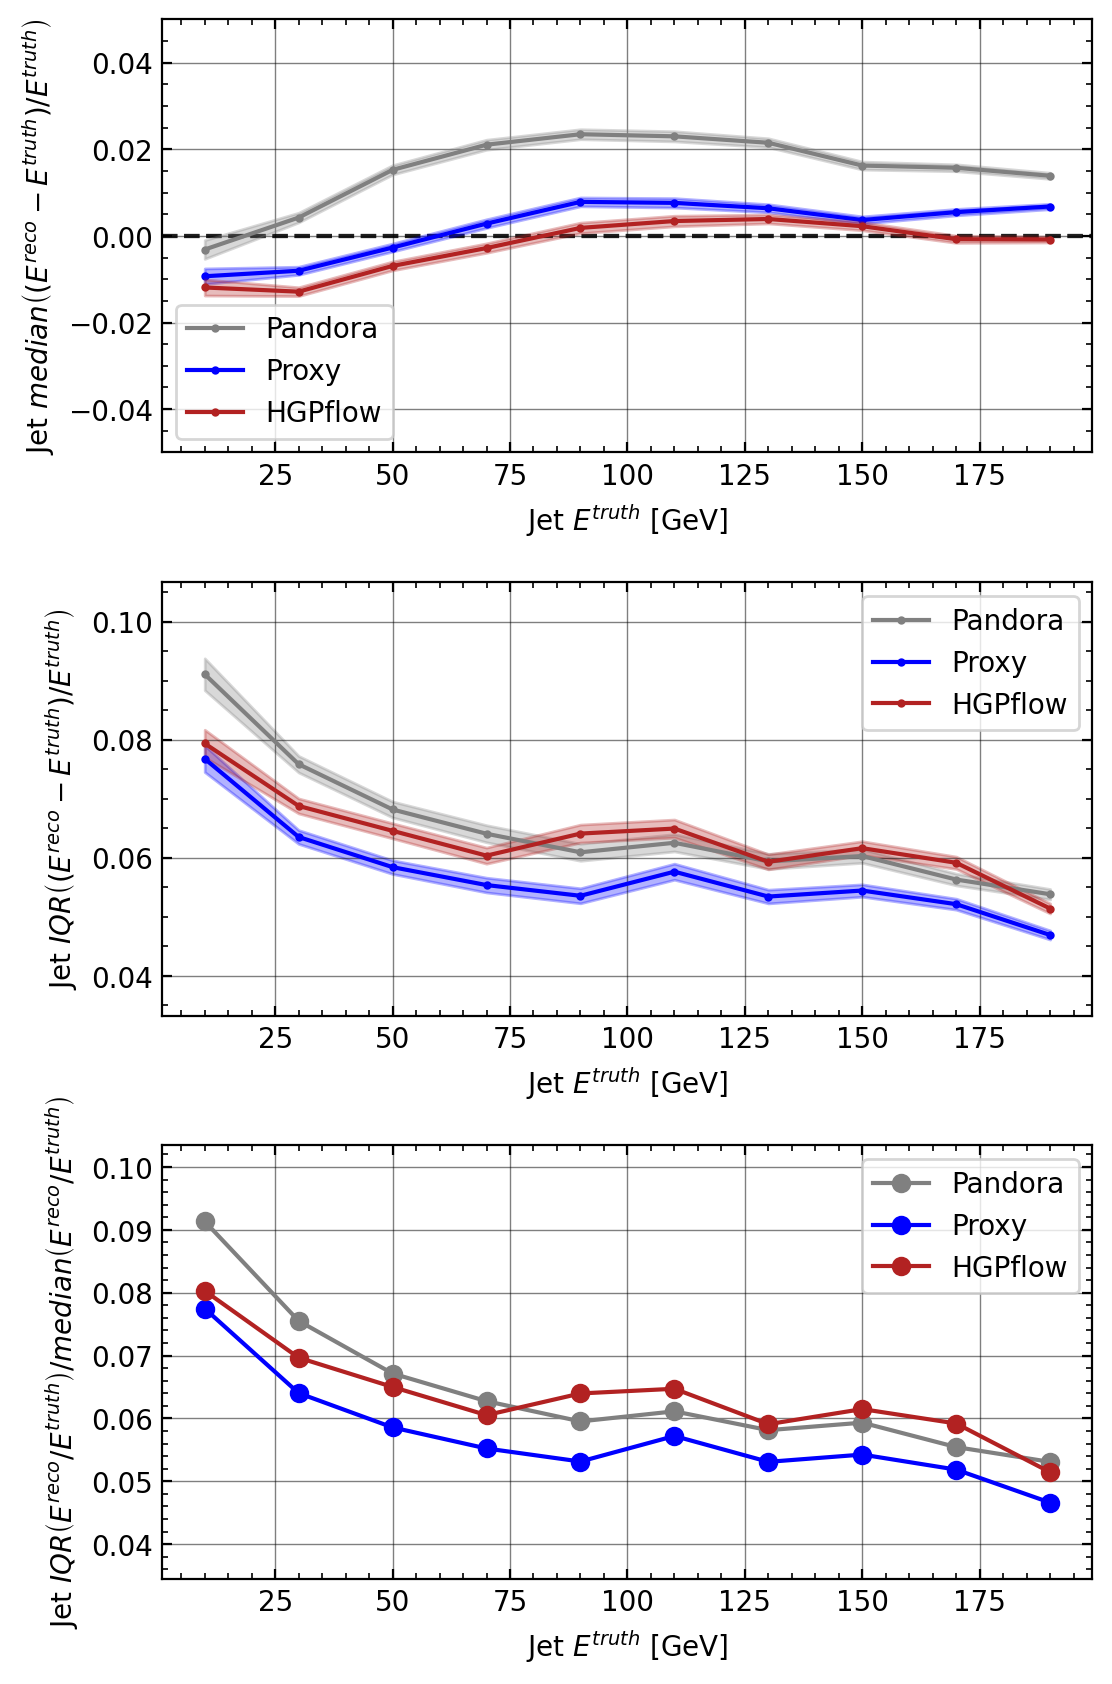

In [24]:
pt_bins = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
fig = plot_jet_response(jet_residual_dict, pt_bins=pt_bins, use_energy=True, separate_figures=False)
if SAVE_FIG:
    if isinstance(fig, list):
        for i, f in enumerate(fig):
            f.savefig(f"{save_dir}/clic_dijet_jet_response_boxplot_{i}.png", dpi=300)
    else:
        fig.savefig(f"{save_dir}/clic_dijet_jet_response_boxplot.png", dpi=300, bbox_inches="tight")

### jet marginal distributions

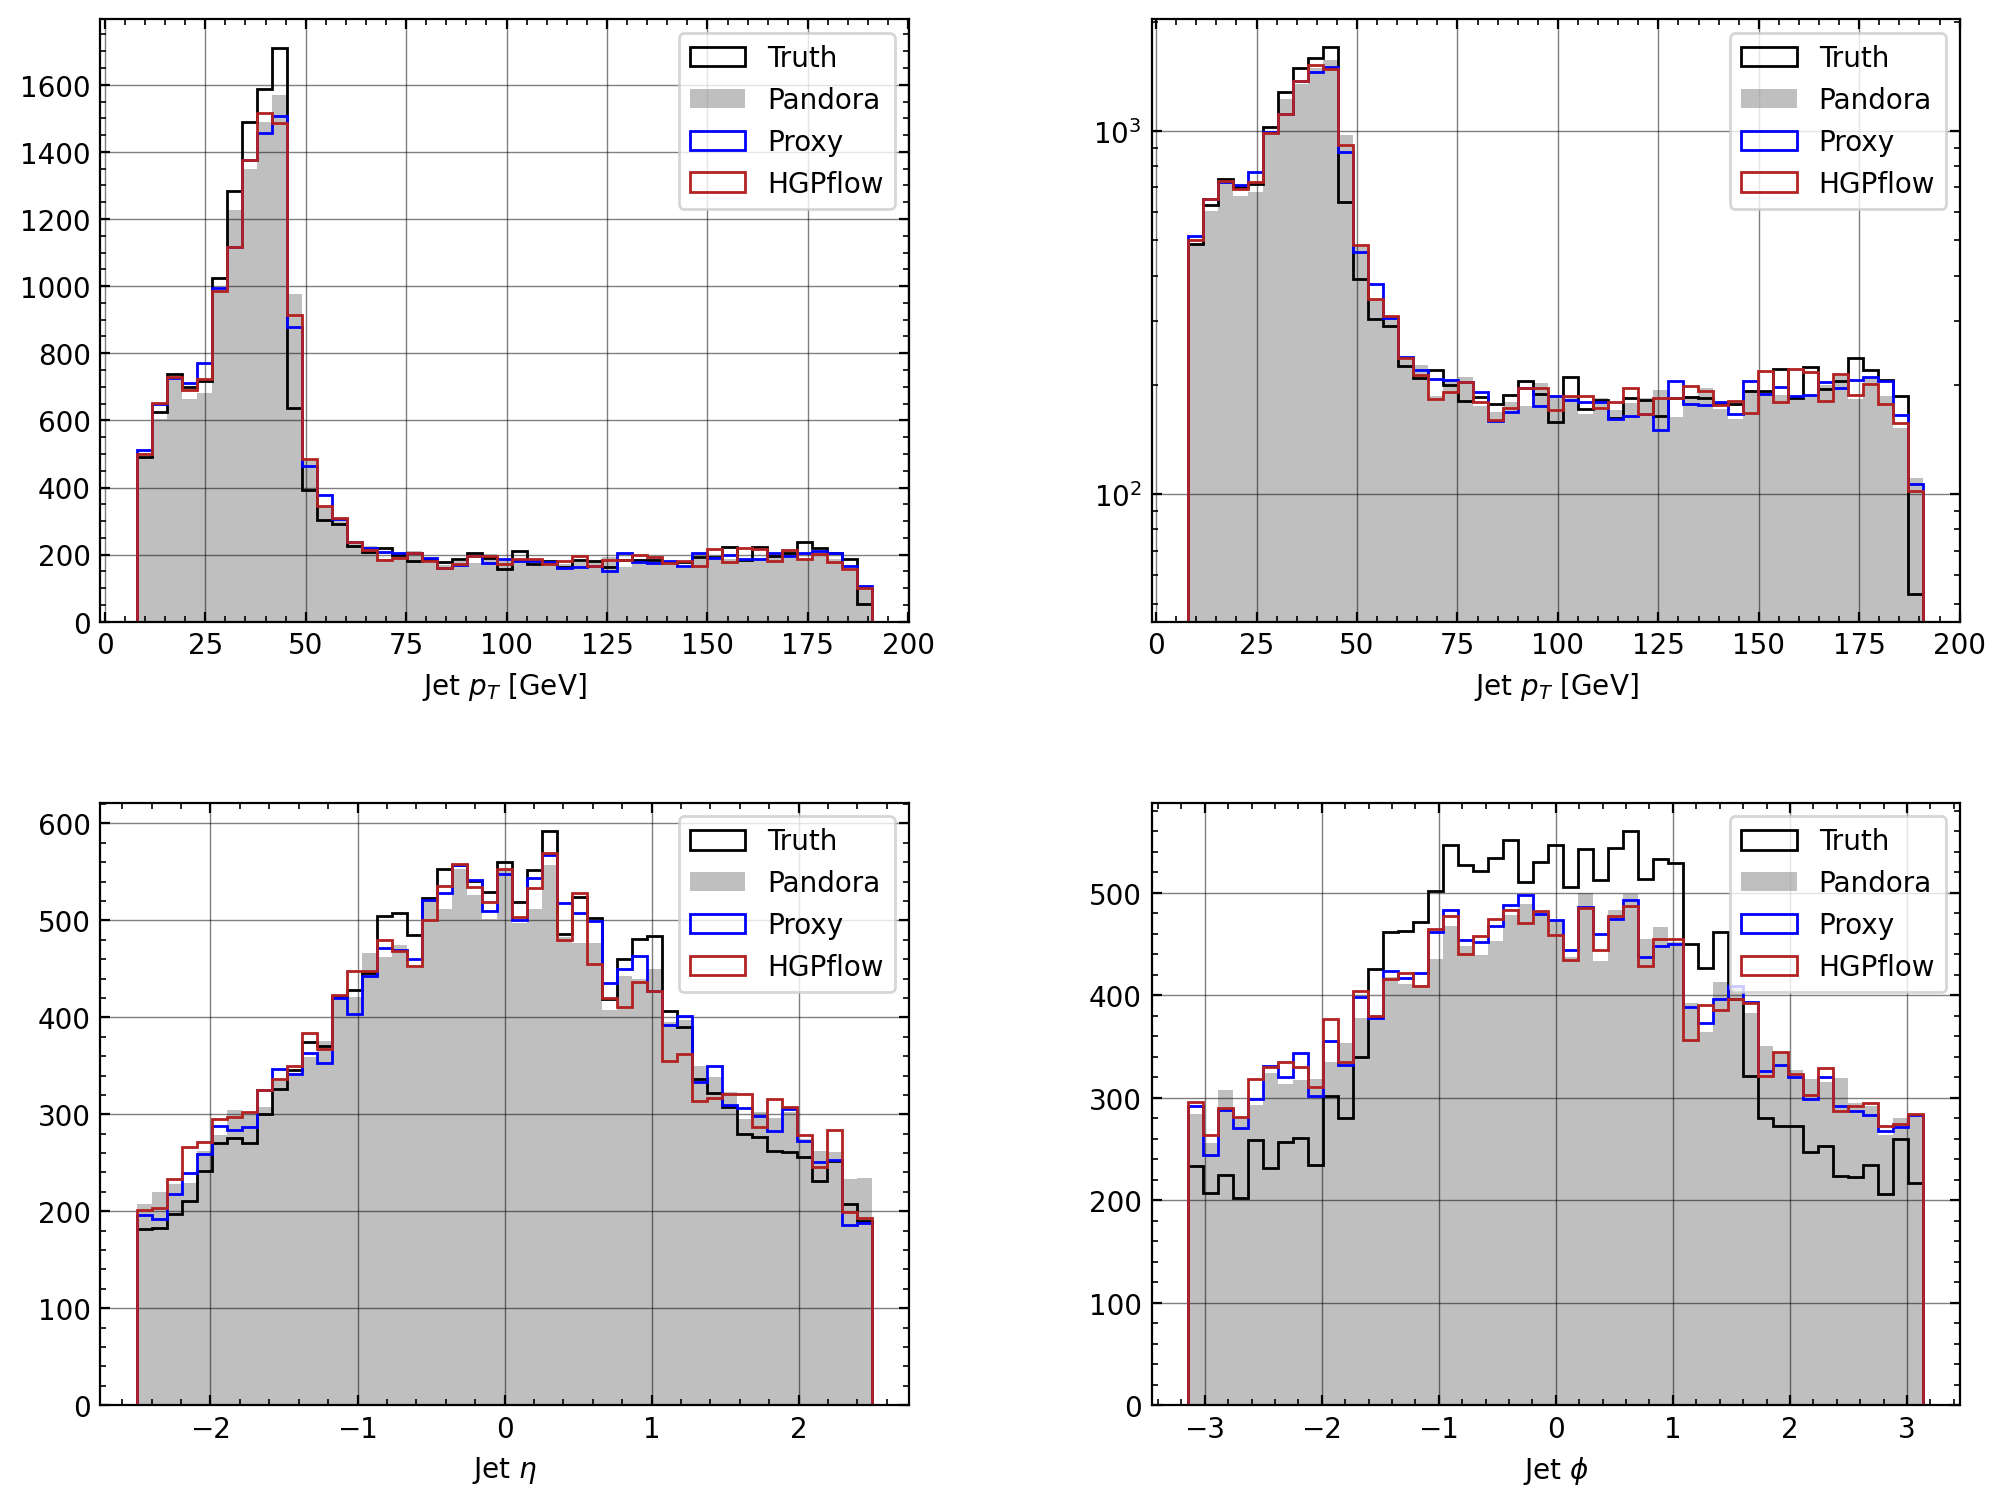

In [25]:
jet_dict = {
    "truth": perf_obj.truth_dict["truth_jets"],
    "pandora": perf_obj.truth_dict["pandora_jets"],
    # 'mlpf': perf_obj.mlpf_dict['jets'],
    # 'mpflow': perf_obj.data['mpflow']['jets'],
    "proxy": perf_obj.data["mpflow"]["proxy_jets"],
    "hgpflow": perf_obj.data["hgpflow"]["jets"],
}

fig = plot_jet_marginals(jet_dict, nleading=1, stylesheet=None)
if SAVE_FIG:
    fig.savefig(f"{save_dir}/clic_dijet_jet_marginals.png", dpi=300, bbox_inches="tight")

## Particle performance

In [26]:
perf_obj.hung_match_particles(flatten=True, return_unmatched=True)

Matching particles...: 100%|██████████| 19722/19722 [00:03<00:00, 5141.09it/s]


In [27]:
style_sheet_eff_fr = {
    "LINE_STYLES": {
        "proxy": "-",
        "hgpflow": "-.",
        "pandora": "--",
    },
    "COLORS": {
        "proxy": {
            "neut had": "mediumseagreen",
            "photon": "tomato",
        },
        "hgpflow": {
            "neut had": "orange",
            "photon": "darkorchid",
        },
        "pandora": {
            "neut had": "dodgerblue",
            "photon": "goldenrod",
        },
    },
}

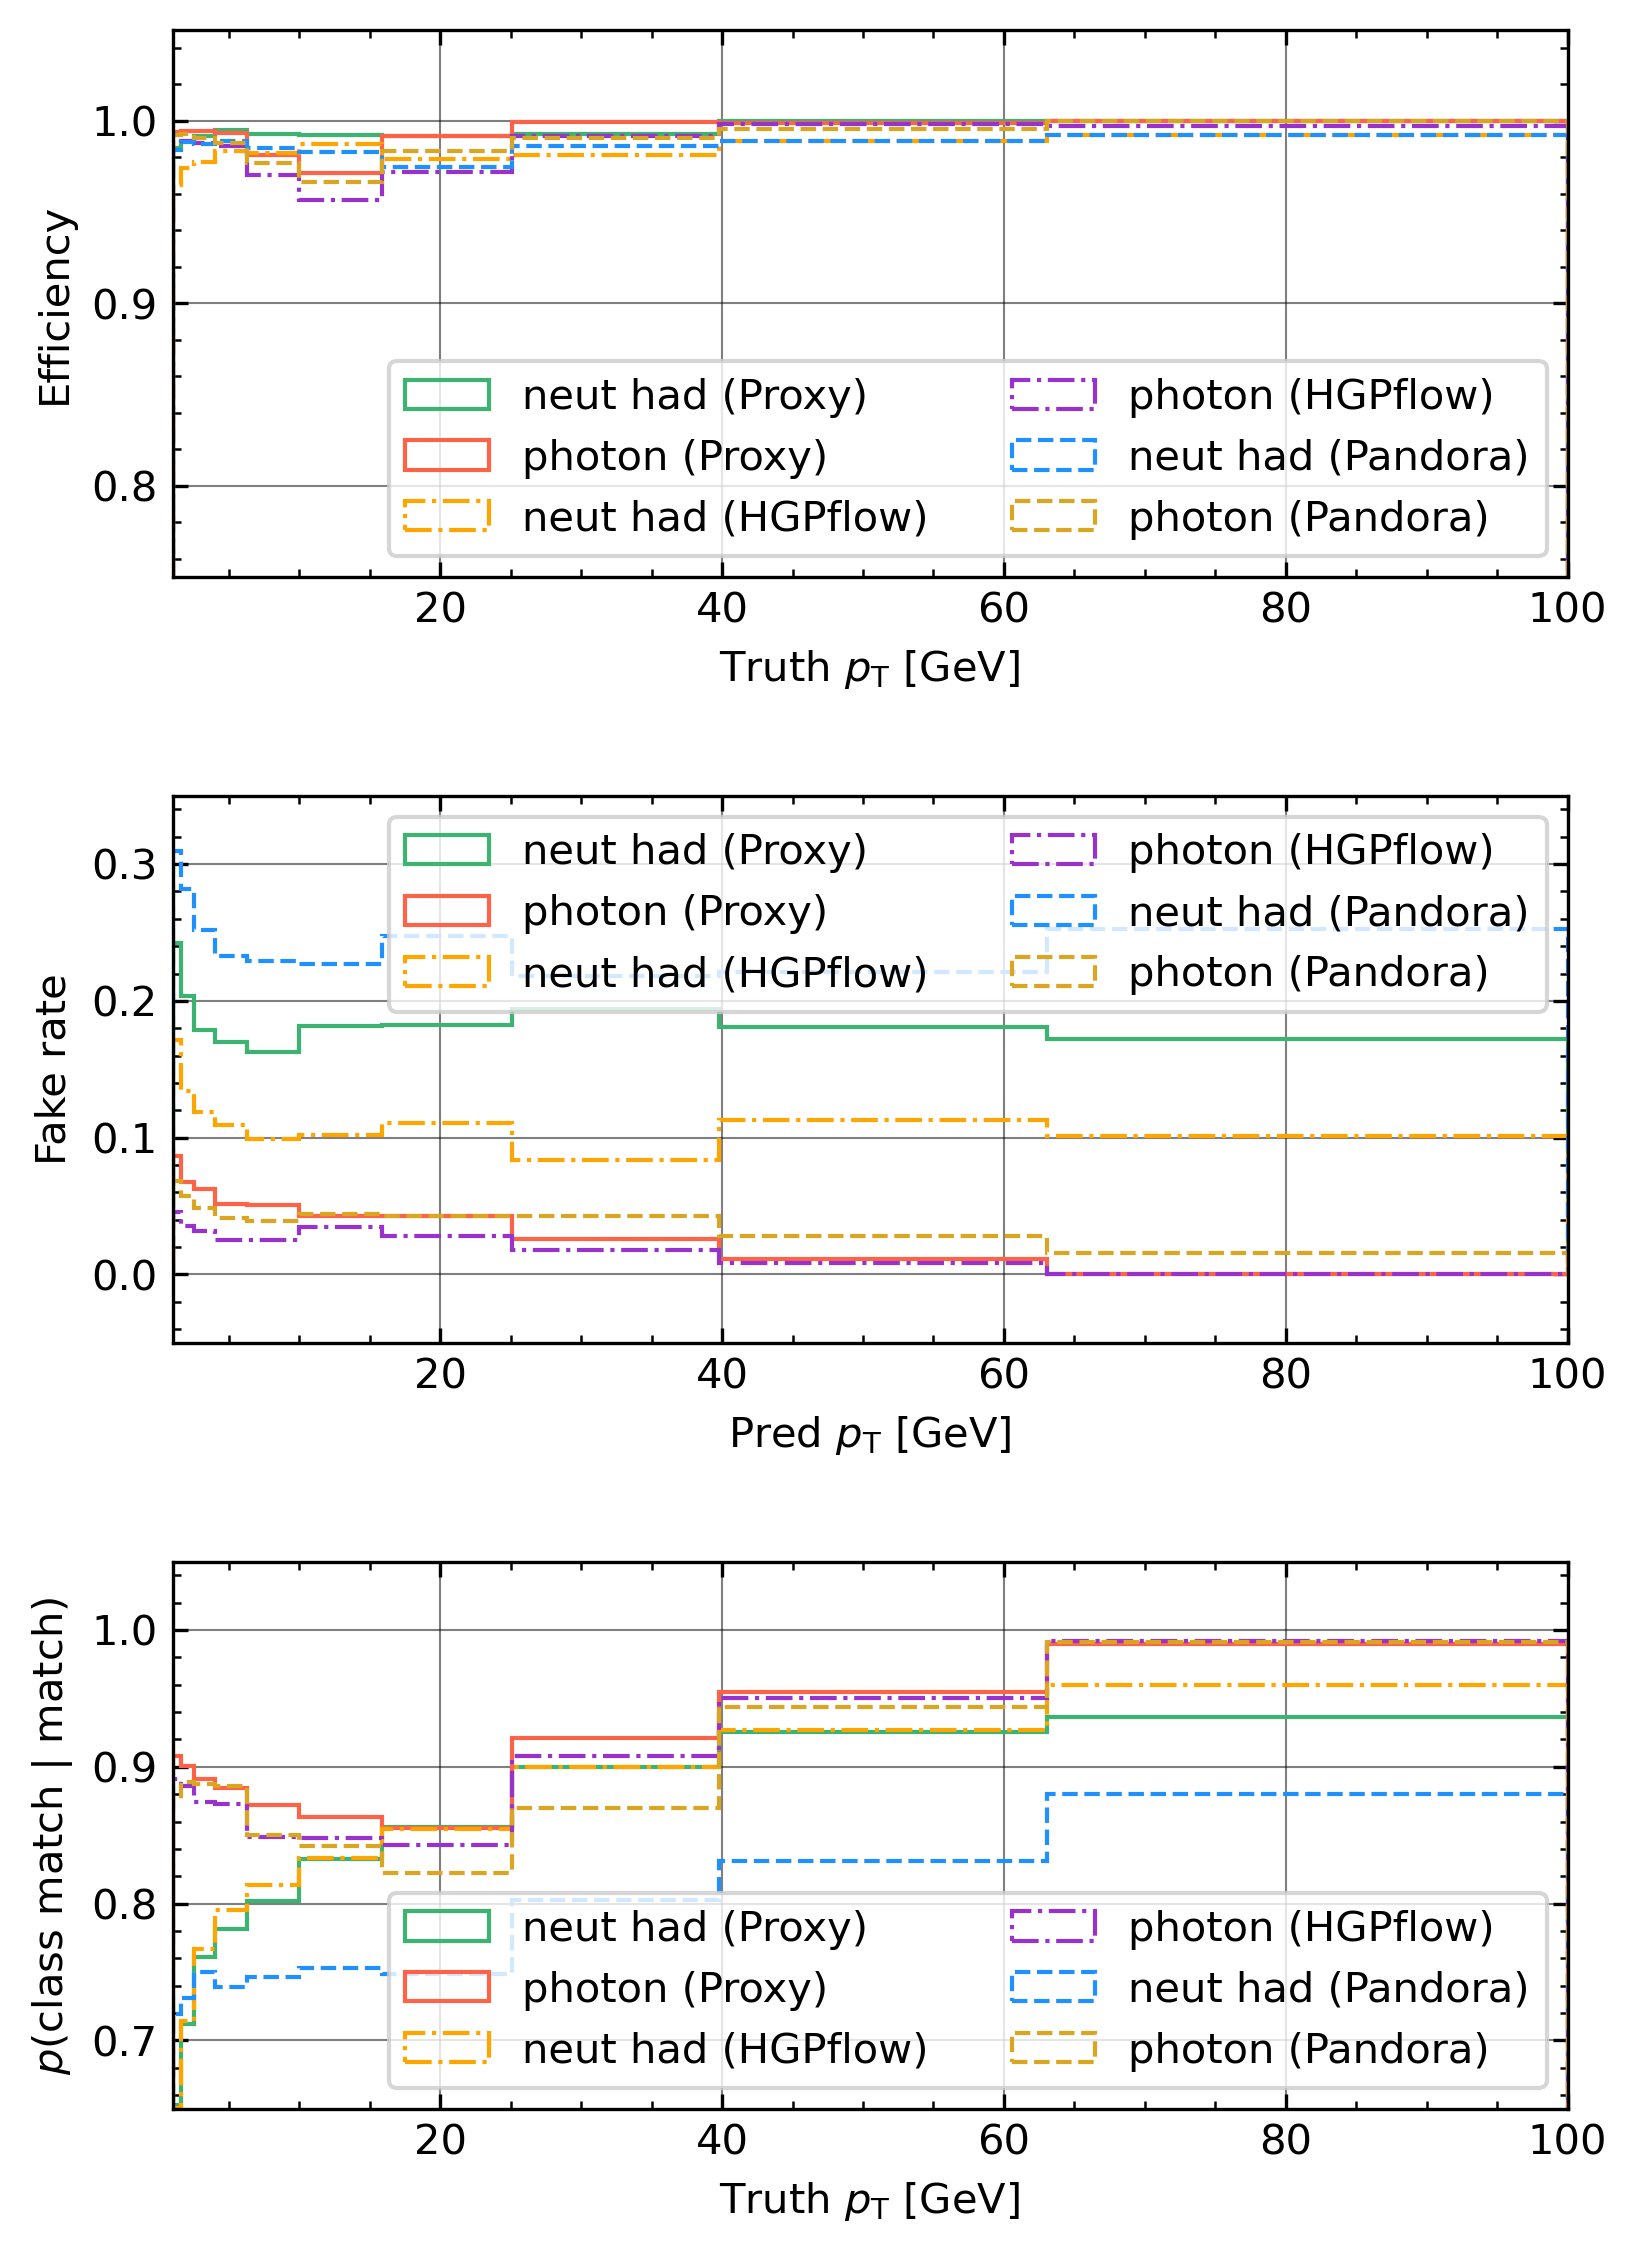

In [28]:
eff_fr_purity_input_dict = {
    "proxy": {
        "ref_matched": perf_obj.data["mpflow"]["matched_proxy_particles"][0],
        "comp_matched": perf_obj.data["mpflow"]["matched_proxy_particles"][1],
        "ref_unmatched": perf_obj.data["mpflow"]["matched_proxy_particles"][2],
        "comp_unmatched": perf_obj.data["mpflow"]["matched_proxy_particles"][3],
    },
    "hgpflow": {
        "ref_matched": perf_obj.data["hgpflow"]["matched_particles"][0],
        "comp_matched": perf_obj.data["hgpflow"]["matched_particles"][1],
        "ref_unmatched": perf_obj.data["hgpflow"]["matched_particles"][2],
        "comp_unmatched": perf_obj.data["hgpflow"]["matched_particles"][3],
    },
    "pandora": {
        "ref_matched": perf_obj.truth_dict["matched_pandora_particles"][0],
        "comp_matched": perf_obj.truth_dict["matched_pandora_particles"][1],
        "ref_unmatched": perf_obj.truth_dict["matched_pandora_particles"][2],
        "comp_unmatched": perf_obj.truth_dict["matched_pandora_particles"][3],
    },
}

fig = plot_eff_fr_purity(eff_fr_purity_input_dict, stylesheet=style_sheet_eff_fr)
if SAVE_FIG:
    fig.savefig(f"{save_dir}/dijet_eff_fr_purity.png", dpi=300, bbox_inches="tight")

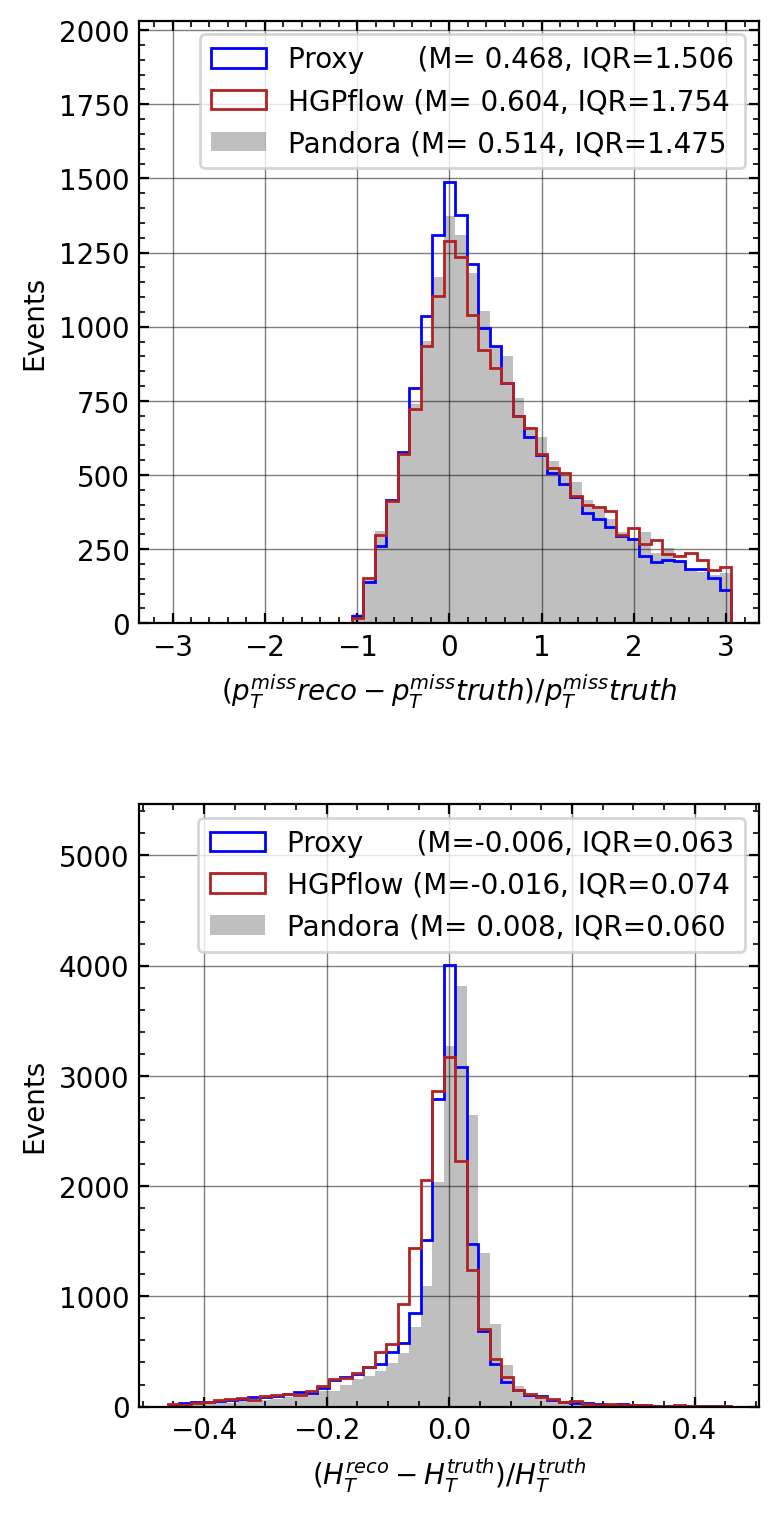

In [29]:
met_res_and_ht_res_input_dict = {
    "proxy": [perf_obj.data["mpflow"]["proxy_pt"], perf_obj.data["mpflow"]["proxy_phi"]],
    "hgpflow": [perf_obj.data["hgpflow"]["pt"], perf_obj.data["hgpflow"]["phi"]],
    "pandora": [perf_obj.truth_dict["pandora_pt"], perf_obj.truth_dict["pandora_phi"]],
}
figs = plot_met_res_and_ht_res(
    perf_obj.truth_dict["particle_pt"], perf_obj.truth_dict["particle_phi"], met_res_and_ht_res_input_dict, stylesheet=None, separate_figures=False
)
if SAVE_FIG:
    if isinstance(figs, list):
        for i, f in enumerate(figs):
            f.savefig(f"{save_dir}/clic_dijet_met_res_and_ht_res_{i}.png", dpi=300)
    else:
        figs.savefig(f"{save_dir}/clic_dijet_met_res_and_ht_res.png", dpi=300, bbox_inches="tight")

/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/performance/plot_helper_particle.py:135: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, ax.get_ylim()[1] * (1 + len(residual_dict) * 0.23))
/tmp/ipykernel_953886/605332041.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


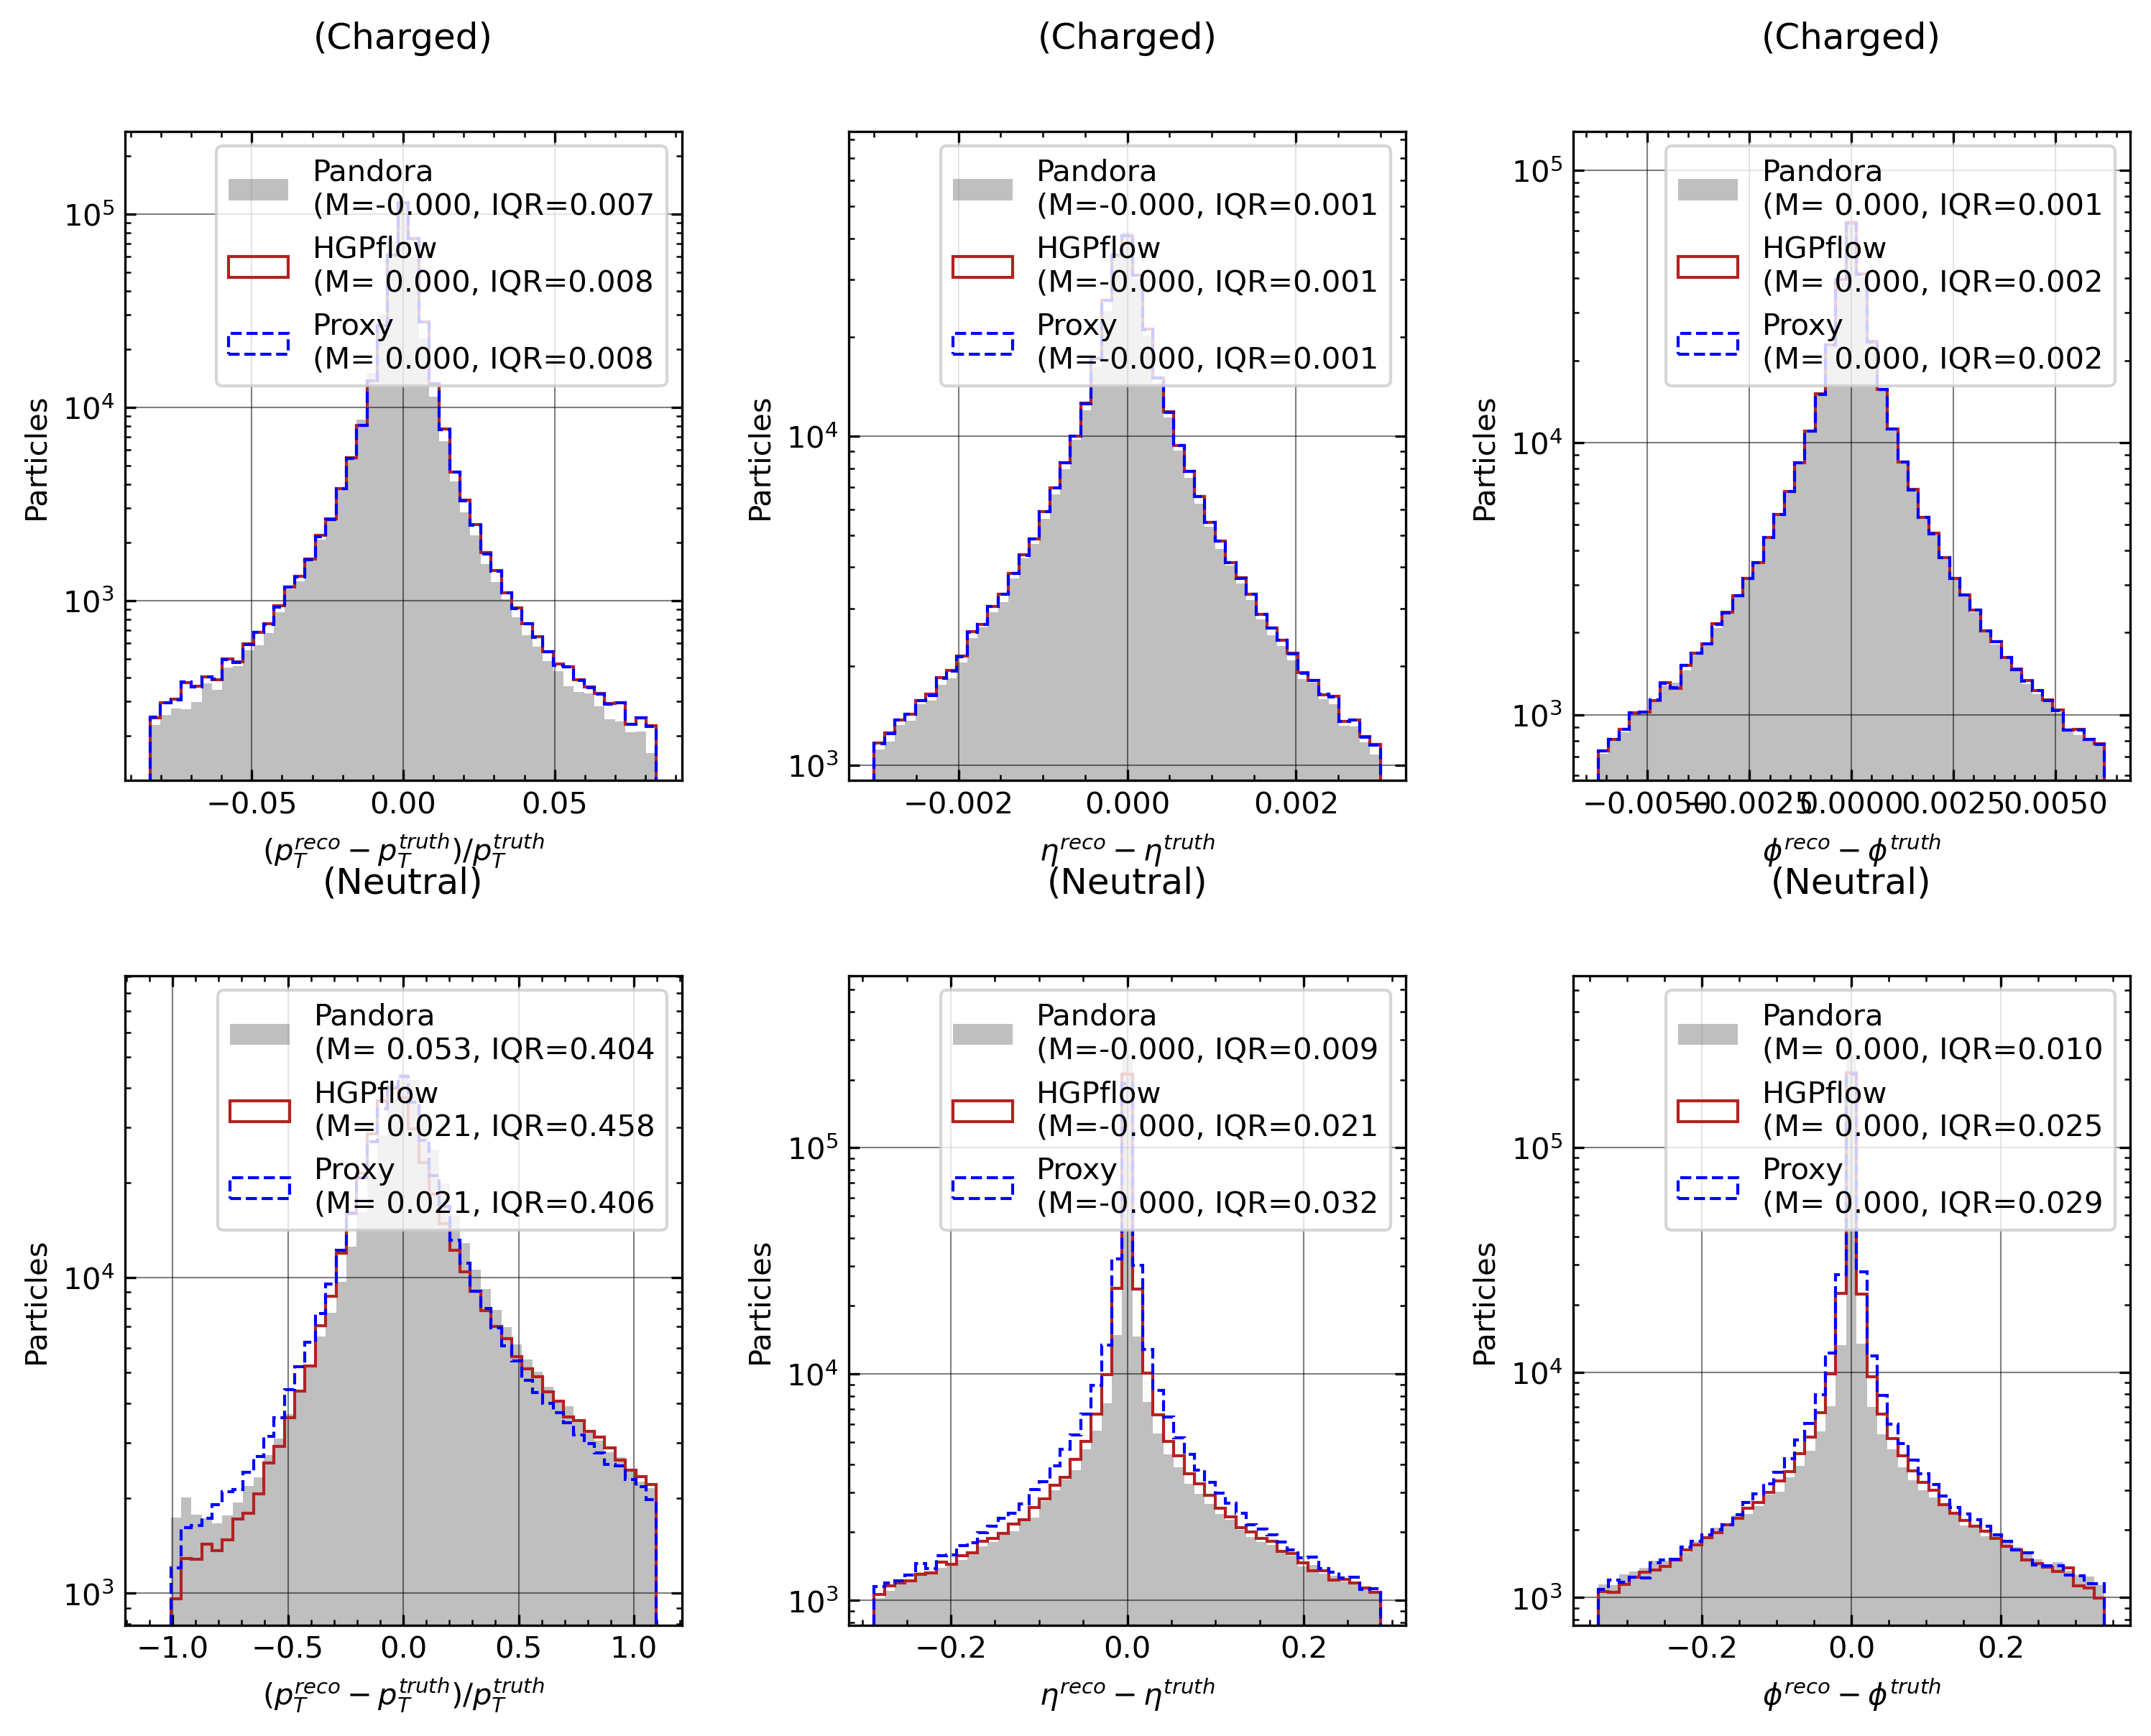

In [30]:
# from pflow.performance.plot_helper_particle import plot_residuals
from hepattn.experiments.clic.performance.style_sheet import LINE_STYLES

style_sheet_part_res = {
    "LINE_STYLES": deepcopy(LINE_STYLES),
}
style_sheet_part_res["LINE_STYLES"]["proxy"] = "--"
# style_sheet_part_res['COLORS']['proxy'] = 'dodgerblue'
# style_sheet_part_res['LINE_STYLES']['proxy'] = '-'

_dict = {
    "pandora": perf_obj.truth_dict["matched_pandora_particles"],
    "hgpflow": perf_obj.data["hgpflow"]["matched_particles"],
    "proxy": perf_obj.data["mpflow"]["matched_proxy_particles"],
}

qs = {"Charged": {"pt": 90, "eta": 80, "phi": 80}, "Neutral": {"pt": 90, "eta": 80, "phi": 80}}
fig = plot_residuals(_dict, pt_relative=True, log_y=True, qs=qs, stylesheet=style_sheet_part_res)
fig.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{save_dir}/dijet_particle_residuals.png", dpi=300, bbox_inches="tight")

In [31]:
_dict = {
    "proxy": perf_obj.data["mpflow"]["matched_proxy_particles"],
    "pandora": perf_obj.truth_dict["matched_pandora_particles"],
    "hgpflow": perf_obj.data["hgpflow"]["matched_particles"],
}

qs = {"Neutral hadron": {"pt": 98, "eta": 75, "phi": 75}, "Photon": {"pt": 99, "eta": 90, "phi": 90}}
figs = plot_residuals_neutrals(_dict, pt_relative=True, log_y=True, qs=qs, stylesheet=None, separate_figures=False)
if SAVE_FIG:
    if isinstance(figs, list):
        figs[0].savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_pt.png", dpi=300, bbox_inches="tight")
        figs[1].savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_eta.png", dpi=300, bbox_inches="tight")
        figs[2].savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_phi.png", dpi=300, bbox_inches="tight")
        figs[3].savefig(f"{save_dir}/dijet_particle_residuals_photon_pt.png", dpi=300, bbox_inches="tight")
        figs[4].savefig(f"{save_dir}/dijet_particle_residuals_photon_eta.png", dpi=300, bbox_inches="tight")
        figs[5].savefig(f"{save_dir}/dijet_particle_residuals_photon_phi.png", dpi=300, bbox_inches="tight")
    else:
        figs.savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_photon.png", dpi=300, bbox_inches="tight")

/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/performance/plot_helper_particle.py:234: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, ax.get_ylim()[1] * (1 + len(residual_dict) * 0.23))


In [45]:
perf_obj.hung_match_particles(flatten=False, return_unmatched=True)

Matching particles...: 100%|██████████| 9876/9876 [00:01<00:00, 5198.02it/s]


In [46]:
import matplotlib.pyplot as plt

In [47]:
def plot_matched_event(idx):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)
    ref_class = perf_obj.data["mpflow"]["matched_proxy_particles"][0]["class"][idx]
    comp_class = perf_obj.data["mpflow"]["matched_proxy_particles"][1]["class"][idx]
    comp_class_hgpf = perf_obj.data["mpflow"]["matched_particles"][1]["class"][idx]
    ax.scatter(
        perf_obj.data["mpflow"]["matched_proxy_particles"][0]["phi"][idx][ref_class < 3],
        perf_obj.data["mpflow"]["matched_proxy_particles"][0]["eta"][idx][ref_class < 3],
        marker="o",
        s=20,
        color="blue",
        label="Truth",
    )
    ax.scatter(
        perf_obj.data["mpflow"]["matched_proxy_particles"][1]["phi"][idx][comp_class < 3],
        perf_obj.data["mpflow"]["matched_proxy_particles"][1]["eta"][idx][comp_class < 3],
        marker="x",
        s=20,
        color="orange",
        label="Proxy",
    )
    ax.scatter(
        perf_obj.data["mpflow"]["matched_particles"][1]["phi"][idx][comp_class_hgpf < 3],
        perf_obj.data["mpflow"]["matched_particles"][1]["eta"][idx][comp_class_hgpf < 3],
        marker="^",
        s=20,
        color="red",
        label="MPflow",
        alpha=0.5,
    )
    fig.suptitle(f"Event {idx}")
    ax.set_xlabel("Phi")
    ax.set_ylabel("Eta")
    fig.legend()
    fig.tight_layout()
    fig.show()

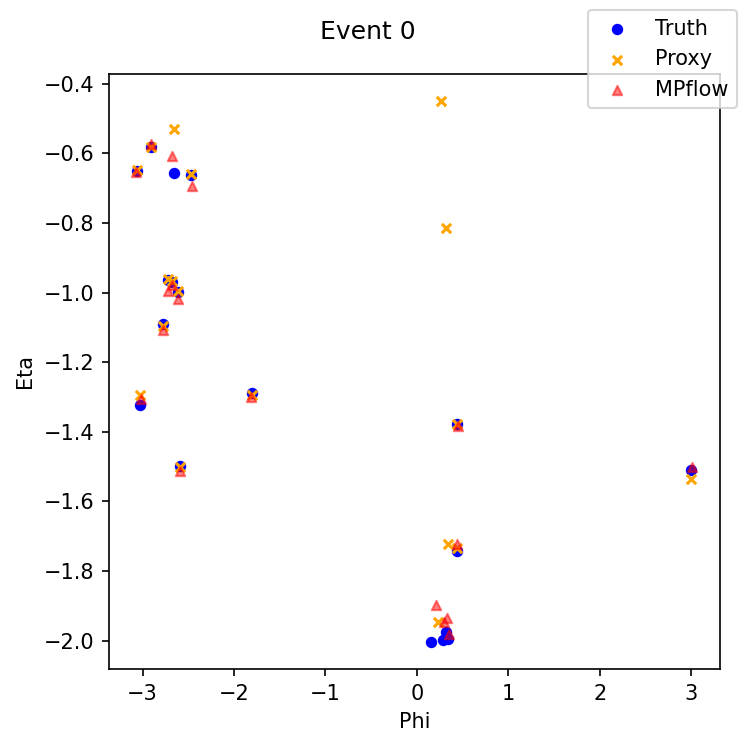

In [49]:
plot_matched_event(0)